In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:52631")
client

Client Scheduler: tcp://127.0.0.1:52631 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 40 Memory: 169.33 GB


In [1]:
import numpy as np
import xarray as xr
import gsw
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [3]:
# year = 1965

z10 = 1
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ystart = -15
yend = 50

In [6]:
xchunk = 250

for year in range(1965,1968):
    for nmemb in range(24,36):
        if nmemb == 24:
            ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (nmemb,year)), 
                                 grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                                 prefix=['diag_ocnSnap'], delta_t=2e2,
                                )
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                        % (nmemb,year)), 
                                                grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                                                prefix=['diag_ocnSnap'], delta_t=2e2,
                                               )],
                           dim='nmemb')
    ds = ds.chunk({'XC':xchunk,'XG':xchunk})
    
    pot_rho = xr.apply_ufunc(jmd95.densjmd95, ds.SALT.isel(time=slice(None,None)).mean('nmemb'), 
                         ds.THETA.isel(time=slice(None,None)).mean('nmemb'),
                         0., # pressure in [dbar]!!!!
                         dask='parallelized', output_dtypes=[float,]
                        ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)).fillna(0.)
    
    nMLD = xr.DataArray(np.nanargmin(np.abs(pot_rho.isel(Z=slice(z10,None))
                                        - pot_rho.isel(Z=z10) - 0.03), 
                                 axis=1) + z10,
                    dims=pot_rho.isel(Z=0).dims, coords=pot_rho.isel(Z=0).coords
                   ).where(ds.maskInC!=0.).compute()
    
    MLD = xr.ones_like(nMLD) * np.nan
    zz, _ = xr.broadcast(ds.Z, ds.hFacC.sel(YC=slice(ystart-12**-1,
                                                     yend+2*12**-1))
                        )

    for i in range(len(MLD.time)):
        MLD.isel(time=i)[:] = zz.isel(Z=nMLD.isel(time=i).fillna(0.).astype(int))

    MLD = MLD.where(ds.maskInC.load()!=0.).to_dataset(name='MLD').to_netcdf(op.join(ddir,'%4d/MLD_%4d.nc' 
                                                                                    % (year,year)))

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

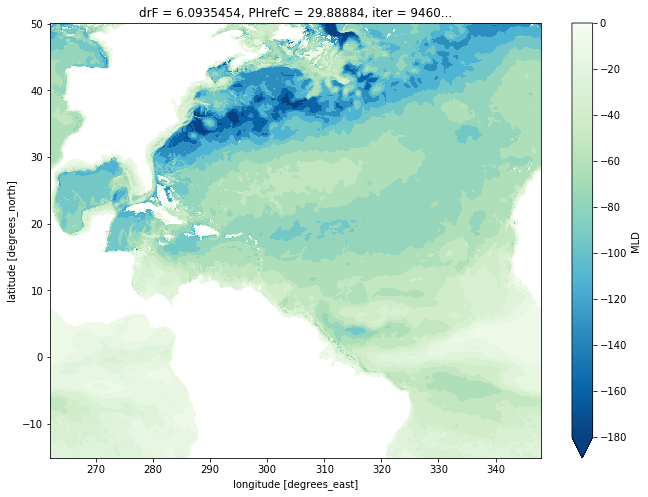

In [5]:
xr.open_dataset(op.join(ddir,'1964/MLD_1964.nc')
               ).MLD.isel(time=0).plot(cmap='GnBu_r', vmin=-180, vmax=0, figsize=(11,8))

In [6]:
for year in range(1963,1968):
    if year == 1963:
        ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (24,year)), 
                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                             prefix=['diag_ocnSnap'], delta_t=2e2,
                            )
        MLD = xr.open_dataset(op.join(ddir,'%4d/MLD_%4d.nc' 
                                      % (year,year))
                             ).MLD.sel(YC=slice(30,40),XC=slice(290,310))
    else:
        MLD = xr.concat([MLD, xr.open_dataset(op.join(ddir,'%4d/MLD_%4d.nc' 
                                                      % (year,year))
                                             ).MLD.sel(YC=slice(30,40),XC=slice(290,310))],
                       dim='time')
MLD = MLD.chunk({'time':1})
MLD

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.DataArray 'MLD' (time: 365, YC: 120, XC: 232)>
dask.array<xarray-<this-array>, shape=(365, 120, 232), dtype=float64, chunksize=(1, 120, 232), chunktype=numpy.ndarray>
Coordinates:
    maskC    (YC, XC) bool dask.array<chunksize=(120, 232), meta=np.ndarray>
    drF      float32 6.0935454
    PHrefC   float32 29.88884
    Depth    (YC, XC) float32 dask.array<chunksize=(120, 232), meta=np.ndarray>
    hFacC    (YC, XC) float32 dask.array<chunksize=(120, 232), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(120, 232), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 232), meta=np.ndarray>
    Z        float32 -3.0467727
  * YC       (YC) float64 30.0 30.08 30.17 30.25 ... 39.67 39.75 39.83 39.92
  * XC       (XC) float32 290.0551 290.14117 290.22723 ... 309.84857 309.93463
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 1825 days 1830 days ... 3640 days 3645 days

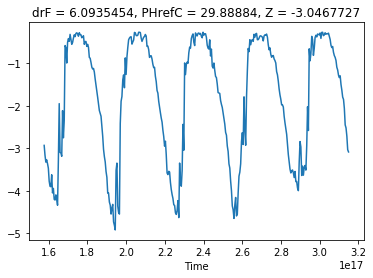

In [9]:
((MLD.where(ds.maskInC.sel(YC=slice(30,40),XC=slice(290,310))!=0.)*ds.rA).sum(['YC','XC']) 
 * (ds.rA.sum(['YC','XC']))**-1).plot()